Importing the required modules

In [286]:
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.xthreat import ExpectedThreat
from socceraction.vaep import VAEP
from socceraction import spadl
from socceraction.spadl.statsbomb import convert_to_actions
from socceraction.spadl import play_left_to_right


import xgboost
import pandas as pd
import numpy as np
import cv2

from tqdm import tqdm
import warnings
import traceback
import json
import os, glob
from scipy.interpolate import interp1d

Setting up the required variables

In [3]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

data = StatsBombLoader(getter="local", root="")    
games_with_three_sixty = [_id[:7] for _id in os.listdir("three-sixty")]

Loading all games with three-sixty

In [67]:
# get all files in matches directory recursively
all_matches = glob.glob('matches/**/*.json', recursive=True)

match_dict = {}
for matches in all_matches:
    with open(matches, "r", encoding="utf8") as file:
        matches_data = json.load(file)

    for match in matches_data:
        if(str(match['match_id']) in games_with_three_sixty):
            match_dict[str(match['match_id'])] = match['home_team']['home_team_id']

Training the action value models

In [4]:
xt_model = ExpectedThreat(l=16, w=12)
VAEP_model = VAEP(nb_prev_actions=1)

In [71]:
all_features, all_labels = [], []

files = os.listdir('three-sixty/')
for _file in tqdm(files):
    file_name = str(_file[:7])
    game_events = data.events(file_name, True)
    game_actions = spadl.statsbomb.convert_to_actions(game_events, match_dict[file_name])
    # compute features and labels
    all_features.append(VAEP_model.compute_features(game, game_actions))
    all_labels.append(VAEP_model.compute_labels(game, game_actions))
    # break

all_features = pd.concat(all_features)
all_labels = pd.concat(all_labels)

VAEP_model.fit(all_features, all_labels)
# xt_model.fit(events)
    # print(events.)

100%|██████████| 51/51 [02:13<00:00,  2.62s/it]
c:\Python38\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Python38\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.55468
[1]	validation_0-auc:0.56045
[2]	validation_0-auc:0.57767
[3]	validation_0-auc:0.61937
[4]	validation_0-auc:0.61936
[5]	validation_0-auc:0.61935
[6]	validation_0-auc:0.66745
[7]	validation_0-auc:0.66795
[8]	validation_0-auc:0.67746
[9]	validation_0-auc:0.68691
[10]	validation_0-auc:0.69166
[11]	validation_0-auc:0.71797
[12]	validation_0-auc:0.72304
[13]	validation_0-auc:0.73436
[14]	validation_0-auc:0.74047
[15]	validation_0-auc:0.74690
[16]	validation_0-auc:0.74618
[17]	validation_0-auc:0.74816
[18]	validation_0-auc:0.75349
[19]	validation_0-auc:0.75391
[20]	validation_0-auc:0.75519
[21]	validation_0-auc:0.75709
[22]	validation_0-auc:0.75798
[23]	validation_0-auc:0.75704
[24]	validation_0-auc:0.75720
[25]	validation_0-auc:0.75630
[26]	validation_0-auc:0.76154
[27]	validation_0-auc:0.76539
[28]	validation_0-auc:0.76700
[29]	validation_0-auc:0.76594
[30]	validation_0-auc:0.76874
[31]	validation_0-auc:0.77197
[32]	validation_0-auc:0.77636
[33]	validation_0-au

Loading tracking content

In [180]:
def loadTrackingContent(path, tracking_content):
    with open(path, 'r') as file:
        raw_tracking = json.loads(file.read())

    for item in raw_tracking:
        tracking_content[item['event_uuid']] = item

def loadTrackingContentFromDir(dir, limit=-1):
    all_tracking_content = {}
    files = glob.glob(dir)
    for _file in (pbar := tqdm(files[:limit])):
        pbar.set_description(("File: " + _file))
        loadTrackingContent(_file, all_tracking_content)

    return all_tracking_content
        

In [86]:
def drawSimple(frame):

    actor_frame = np.zeros(shape=(80,120), dtype=np.uint8)
    team_frame = np.zeros(shape=(80,120), dtype=np.uint8)
    opp_frame = np.zeros(shape=(80,120), dtype=np.uint8)

    actor_x, actor_y = -1, -1

    for player in frame['freeze_frame']:
        if(player['actor']):
            actor_x = int(player['location'][0])
            actor_y = int(player['location'][1])

            # draw circle at actor_x, actor_y on actor_frame with cv2
            cv2.circle(actor_frame, (actor_x, actor_y), 3, (255,255,255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
        elif(player['teammate']):
            # draw circle at x, y on team_frame with cv2
            cv2.circle(team_frame, (int(player['location'][0]), int(player['location'][1])), 3, (255,255,255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
        elif(not player['teammate']):
            # draw circle at x, y on opp_frame with cv2
            cv2.circle(opp_frame, (int(player['location'][0]), int(player['location'][1])), 3, (255,255,255), thickness=-1, lineType=cv2.LINE_AA, shift=0)

    returning = np.array([actor_frame, team_frame, opp_frame], dtype=np.uint8).copy()
    return returning

Get the VAEP for all the actions within each game

In [186]:
VAEP_model.rate(game, convert_to_actions(game_events, 0))

,offensive_value,defensive_value,vaep_value
0,0.000000,-0.000000,0.000000
1,-0.000848,-0.004117,-0.004964
2,0.007990,0.003771,0.011761
3,-0.009938,0.000624,-0.009314
4,-0.000301,-0.000363,-0.000664
...,...,...,...
2197,0.195692,0.000141,0.195833
2198,0.146895,-0.000103,0.146792
2199,-0.228911,-0.001300,-0.230210
2200,0.009522,0.153106,0.162628


In [199]:
action

game_id                3788741
original_event_id          NaN
period_id                    1
time_seconds              44.0
team_id                    914
player_id               7038.0
start_x              20.647059
start_y               5.164557
end_x                     22.5
end_y                10.070886
type_id                     21
result_id                    1
bodypart_id                  0
action_id                   20
type_name              dribble
result_name            success
bodypart_name             foot
Name: 20, dtype: object

In [247]:
def get_action_vector(action):
    return [1 if action['type_name'] == a  else 0 for a in good_actions]

914

In [287]:
files = os.listdir('three-sixty/')

tracking_content = loadTrackingContentFromDir('three-sixty/*.json', limit=-1)
good_actions = ['pass', 'shot', 'dribble', 'clearance']

x = []
y = []
rewards = []
event_ids = []
terminals = []

failcount = 0
successcount = 0
for _file in tqdm(tqdm_files := tqdm(files)):
    file_name = _file[:7]

    game_events = data.events(file_name, True)
    tqdm_files.set_description(("File: " + _file + " ... " + f"{failcount}/{failcount+successcount}" ))
    ac = spadl.add_names(convert_to_actions(game_events, match_dict[file_name]))
    ac = play_left_to_right(ac, match_dict[file_name])
    actions_rated = VAEP_model.rate(game, ac)

    for rated_action in range(len(ac)):

        # get the action type to see whether or not to discard
        action = ac.iloc[rated_action]
        if(action['type_name'] not in good_actions):
            continue
            
        # get the event id to get the tracking data and draw the image
        # try:
        try:
            related_event = tracking_content[str(action['original_event_id'])]
            successcount  += 1
        except KeyError as e:
            failcount += 1
            continue

        x.append(drawSimple(related_event))
        
        # get the action vector
        v1 = get_action_vector(action)
        v1.append(2*(action['end_x']/120)- 1)
        v1.append(2*(action['end_y']/80) - 1)
        # get the ending x, y position

        y.append(v1)
        rewards.append(actions_rated.iloc[rated_action]['vaep_value'])
        terminals.append(1-action['result_id'])

        event_ids.append(action['original_event_id'])

100%|██████████| 51/51 [04:22<00:00,  5.15s/it]


In [268]:
a = np.array(rewards)

Save the dataset to disk

In [288]:
np.savez("saved_datasets\\VAEP_dataset.npz", np.array(x, dtype=np.uint8), np.array(y), np.array(rewards), np.array(event_ids), np.array(terminals))

Sample action output

In [127]:
vals = ac.type_id.unique()
len(vals)

19

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
0,3788741,bbc398f7-c784-4958-a504-37b583caf97a,1,0.0,909,11086.0,52.941176,33.569620,77.205882,23.929114,0,1,0,0,pass,success,foot
1,3788741,605315c0-8960-4f53-94cb-87ae77e86750,1,2.0,909,8963.0,77.205882,23.929114,73.941176,25.306329,21,1,0,1,dribble,success,foot
2,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,1,4.0,909,8963.0,73.941176,25.306329,43.500000,64.384810,0,1,0,2,pass,success,foot
3,3788741,37105d1f-4313-4db6-b8ba-76c224e488ca,1,6.0,909,8541.0,43.500000,64.384810,43.764706,64.126582,21,1,0,3,dribble,success,foot
4,3788741,362b7952-6885-41e0-9821-57a6f3517102,1,6.0,909,8541.0,43.764706,64.126582,43.764706,64.126582,19,0,0,4,bad_touch,fail,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,3788741,985ba1fc-5cf3-4eac-b235-631766fbaf0f,2,2876.0,914,6993.0,29.117647,17.043038,13.764706,12.567089,0,1,0,2197,pass,success,foot
2198,3788741,16f51156-0174-45f4-a5fe-6adb4efa1a41,2,2877.0,914,7471.0,13.764706,12.567089,9.352941,16.010127,21,1,0,2198,dribble,success,foot
2199,3788741,7b9af076-b692-41a9-a745-162d0d57bcfc,2,2879.0,914,7471.0,9.352941,16.010127,9.352941,16.010127,7,0,0,2199,take_on,fail,foot
2200,3788741,e2951cf0-095b-4ea3-b4ee-da19be75ed65,2,2879.0,909,10349.0,96.441176,51.215190,96.441176,51.215190,9,0,0,2200,tackle,fail,foot


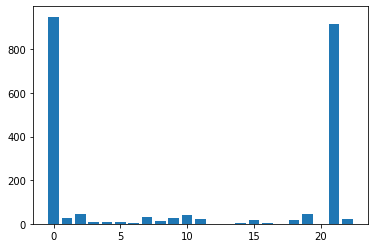

In [243]:
ac = convert_to_actions(game_events, 0)
ac = spadl.add_names(ac)

# get all the distinct values in the action_id column

# draw bar chart of the number of times each val appears
plt.bar(vals, ac.type_id.value_counts())

# draw a histogram of the number of times each type_name appears

# c = []
# print(len(ac))
# for i in range(len(ac)):
#     good_actions = ['pass', 'shot', 'dribble', 'clearance']

#     if(ac.type_name[i] in bad_actions): continue
#     this_row = [ a for]
    
#     c.append(this_row)
#     if(not any(this_row)):
#         print(ac.type_name[i])
#         print("That is the other from ", this_row)
#         break

# count the nans in the original_event_id column
ac